In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Supervised Texture Classification 2: The FCNT
The goal of this notebook is to look into deep learning solutions for supervised texture classification. Texture classification has unique difficulties, namely related to texture features themselves. Texture features have multi-scale information that is recognized by the eye as a repeating pattern. As such, humans determine a texture by recognizing this pattern. This challenge is uniquely different than recognizing objects, which is much more reliant on shape information. 

Neural networks for semantic segmentation exist in many forms. Two of the more popular ones include U-Net and the fully convolutional network (FCN). However, Andrearczyk et al. [1] showed that by slightly altering the shape of the usual FCN architecture, they were able to perform better on textures. This modified FCN is known as the Fully Connected Network for Textures (FCNT). We construct it in Keras below.

In [2]:
layer_number = [20,60,40,20,20,20,5]
layer_size = [7,5,3,3,3,3,3]
print(sum(layer_number))
input_ = keras.layers.Input(shape=[256,256,1])

hidden1 = keras.layers.Conv2D(layer_number[0],layer_size[0],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(input_)
maxPool1 = keras.layers.MaxPool2D(2)(hidden1)

hidden2 = keras.layers.Conv2D(layer_number[1],layer_size[1],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool1)
maxPool2 = keras.layers.MaxPool2D(2)(hidden2)

hidden3 = keras.layers.Conv2D(layer_number[2],layer_size[2],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool2)
maxPool3 = keras.layers.MaxPool2D(2)(hidden3)

hidden4 = keras.layers.Conv2D(layer_number[3],layer_size[3],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool3)
maxPool4 = keras.layers.MaxPool2D(2)(hidden4)

hidden5 = keras.layers.Conv2D(layer_number[4],layer_size[4],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(maxPool4)
hidden6 = keras.layers.Conv2D(layer_number[5],layer_size[5],kernel_regularizer=keras.regularizers.l2(.0001),activation = 'relu',padding = 'same')(hidden5)

#upsample
maxPool2Up = keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(maxPool2)
maxPool3Up =  keras.layers.UpSampling2D(size=(4, 4), interpolation='nearest')(maxPool3)
hidden6Up =  keras.layers.UpSampling2D(size=(8, 8), interpolation='nearest')(hidden6)

#combine
combined = keras.layers.Concatenate()([maxPool1,maxPool2Up,maxPool3Up,hidden6Up])
#upsample
combinedUp = keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(combined)
output_ = keras.layers.Conv2D(5,1,padding = 'same',activation = 'softmax')(combinedUp)
    
model = keras.Model(inputs = input_, outputs = output_)

185


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 20) 1000        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 20) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 60) 30060       max_pooling2d[0][0]              
______________________________________________________________________________________________

To see it perform, we use the Outex dataset, as well as the training data we generated in the previous notebook. We now load in this data. We use 900 images for training, with 25 images for validation, and reserve 75 images for the test set.

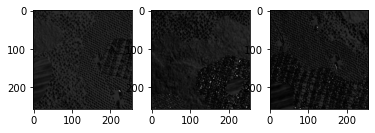

In [4]:
train_full = np.zeros([1000,256,256,1],'float32')
trainlab_full = np.zeros([1000,256,256,1],'int8')
for i in range(0,1000):
    train_full[i,:,:,0] = plt.imread('data/000/data'+str(i)+'.png')[:,:,0]
    train_full[i,:,:,0] -= np.min(train_full[i,:,:,0])
    train_full[i,:,:,0] /= np.max(train_full[i,:,:,0])
    temp1 = plt.imread('data/GT/GT'+str(i)+'.png')[:,:,0]
    temp3 = np.copy(temp1)
    temp2 = np.unique(temp1)
    for k in range(0,5):
        temp3[temp1==temp2[k]] = k
    trainlab_full[i,:,:,0] = temp3


#We now change our label images to actual labels, 
test = plt.imread('data/000/problem.ras')

train = train_full[:900,:,:,:]
trainlab = trainlab_full[:900,:,:,:]
valid = train_full[900:925,:,:,:]
validlab = trainlab_full[900:925,:,:,:]
test = train_full[925:,:,:,:]
testlab = trainlab_full[925:,:,:,:]
del train_full
del trainlab_full 
plt.figure()
for i in range(1,4):
    plt.subplot(130+i)
    plt.imshow(train[i,:,:,:],cmap = 'gray')

We train using an Adam optimizer, and using the validation data, we determined a stopping point was roughly 25 epochs. Training here, we reach a validation accuracy of ~93.8%.

In [5]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train, trainlab,
          batch_size = 32,
          epochs = 25, 
          verbose = 2, 
          validation_data = [valid, validlab])

Train on 900 samples, validate on 25 samples
Epoch 1/25
900/900 - 324s - loss: 1.5938 - accuracy: 0.2805 - val_loss: 1.5781 - val_accuracy: 0.2798
Epoch 2/25
900/900 - 322s - loss: 1.4526 - accuracy: 0.4633 - val_loss: 1.3843 - val_accuracy: 0.5287
Epoch 3/25
900/900 - 322s - loss: 1.3258 - accuracy: 0.5908 - val_loss: 1.3238 - val_accuracy: 0.5933
Epoch 4/25
900/900 - 321s - loss: 1.2708 - accuracy: 0.6454 - val_loss: 1.3066 - val_accuracy: 0.6090
Epoch 5/25
900/900 - 321s - loss: 1.2611 - accuracy: 0.6539 - val_loss: 1.3176 - val_accuracy: 0.5940
Epoch 6/25
900/900 - 321s - loss: 1.2564 - accuracy: 0.6582 - val_loss: 1.2970 - val_accuracy: 0.6172
Epoch 7/25
900/900 - 321s - loss: 1.2496 - accuracy: 0.6643 - val_loss: 1.2936 - val_accuracy: 0.6202
Epoch 8/25
900/900 - 322s - loss: 1.2475 - accuracy: 0.6660 - val_loss: 1.2928 - val_accuracy: 0.6212
Epoch 9/25
900/900 - 323s - loss: 1.2463 - accuracy: 0.6668 - val_loss: 1.2926 - val_accuracy: 0.6196
Epoch 10/25
900/900 - 323s - loss: 1.

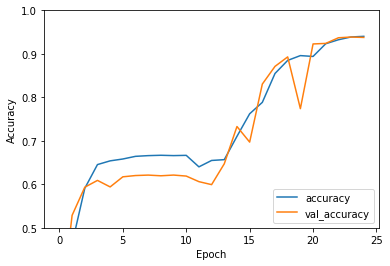

In [6]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We now see how accurately the model predicts an image from the test set. We also evaluate the model to see how well it performs over the entire test set. 

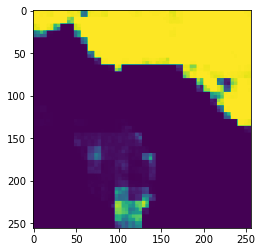

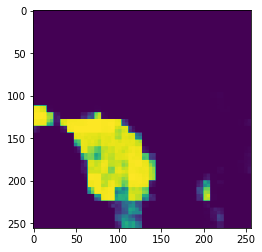

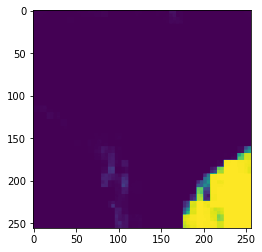

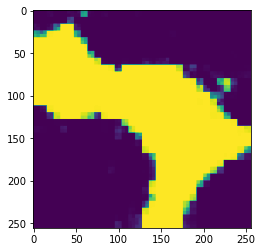

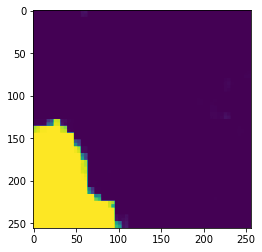

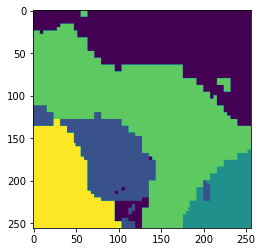

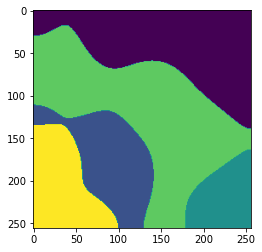

In [7]:
res = model.predict(test)
plt.figure()
plt.imshow(res[0,:,:,0])
plt.figure()
plt.imshow(res[0,:,:,1])
plt.figure()
plt.imshow(res[0,:,:,2])
plt.figure()
plt.imshow(res[0,:,:,3])
plt.figure()
plt.imshow(res[0,:,:,4])
res = np.argmax(res[0,:,:,:],axis = -1)
plt.figure();
plt.imshow(res)
plt.figure();
plt.imshow(testlab[0,:,:,0])

In [8]:
score = model.evaluate(test, testlab, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.9863212156295776
Test accuracy: 0.9365641474723816


Our final result hovers around 93.7% accurate. Certainly, this model could be fine-tuned further. However, This provides a good benchmark for the overall performance of the FCNT on the Outex dataset. 

[1] Andrearczyk, Vincent & Whelan, Paul. (2017). Texture segmentation with Fully Convolutional Networks. 